# Assessment of DigitalX Ad-Placement Sales Sample

## Summary

This notebook assesses a sample of 100,000 individual ad-placement sales from a recent day, from 10 sources. For each source, this assessment evaluates whether there are signs of General Invalid Traffic (GIVT) and:

* Identifies whether the source is a bad source serving fraudulent traffic, and
* Recommends a course of action for the exchange to take with the source.

Below, we summarize the degree to which each source is characterized by fraudulent activity and the recommended course of action if determined to be at least moderately likely to be fraudulent:

| Source        | Fraud Judgement| Recommendation|
| ------------- |:-------------:| :-----: |
| A     | Near Certain | Eject |
| B     | Unlikely      |   |
| C     | Unlikely      |  |
| D     | Unlikely      |  |
| E     | Unlikely      |  |
| F     | Near Certain  | Eject |
| G | Unlikely | |
| H | Moderately Likely | Request Chargeback |
| I | Unlikely | |
| J | Very Likely | Eject |

For the sources identified as possibly fraudulent, we summarize the types of fraud being committed below:

* Ad requests that are being produced at an unnatural scale by a small number of users: **Source A**
* Ad requests that appear to come from scripts running off data center servers rather than standard broadband or wireless telecom providers: **Source F**
* Ad requests that have been made by scrapers or other self-identified bots visiting the site: **Sources A, H, J**
* Ad requests that show signs of browser/IP manipulation (e.g., request inconsistencies), implying that the true source of the traffic is being obscured through spoofing: **Source J**

The data analysis which follows to support these findings in greater detail. This analysis proceeds as follows:

* An hour-by-hour analysis across all sources to identify any problematic patterns of activity (Two classes are identified)
* Deeper analysis of Source A, reflecting one problematic pattern (Unusual peaks over short time periods)
* Deeper analysis of Sources E, F, H and J, reflecting another problematic pattern (Constant activity over all 24 hours)
* Selected deeper analysis of sources without problematic patterns of activity but other concerns

## Data Analysis

First, make the necessary imports and read in and inspect the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
givt_df = pd.read_csv('fq_test/fq_analytics_givt_test_data.csv')

In [3]:
givt_df.head()

,Source,Timestamp,IP,Domain,OS,Browser,ISP
0,E,2019-01-01 05:00:00,209.14.199.162,frommers.com,Windows 10,Chrome,Marriott International
1,F,2019-01-01 05:00:00,1.50.192.253,com.cleaner.app,Android 8,Chrome,Amazon Web Services
2,H,2019-01-01 05:00:00,191.166.255.225,wikipedia.org,Windows 10,Chrome,AT&T
3,H,2019-01-01 05:00:06,157.156.30.60,com.dropbox.android,Android 8,Chrome,AT&T
4,H,2019-01-01 05:00:07,233.129.121.140,netflix.com,Windows 10,Edge,Wide Open West


In [4]:
givt_df.tail()

,Source,Timestamp,IP,Domain,OS,Browser,ISP
99995,G,2019-01-02 04:59:54,215.73.127.0,sexamusements.com,Mac OSX,Safari,Wide Open West
99996,E,2019-01-02 04:59:55,209.14.199.94,frommers.com,Windows 10,Chrome,Marriott International
99997,C,2019-01-02 04:59:56,23.30.225.67,nytimes.com,Mac OSX,Safari,Comcast
99998,H,2019-01-02 04:59:57,1.48.197.93,com.intuit.turbotax.mobile,Android 8,Chrome,Amazon Web Services
99999,E,2019-01-02 04:59:58,209.14.199.197,lonelyplanet.com,Android 8,Chrome,Marriott International


### Analysis across all sources hour-by-hour

First, let's examine the requests across all sources by looking at the number of requests over the given day's activity for each source. To facilitate this analysis, let's break down and visualize the activity for each source on an hourly basis.

In [5]:
# Extract the hour of the day from each Timestamp
givt_df['Hour_of_Day'] = givt_df['Timestamp'].apply(lambda x: pd.to_datetime(x).hour)

In [6]:
# For each source and each hour of the day, get the count of requests
givt_by_src = givt_df.groupby(['Source', 'Hour_of_Day']).count().reset_index().rename(columns={'Timestamp': 'Count'})

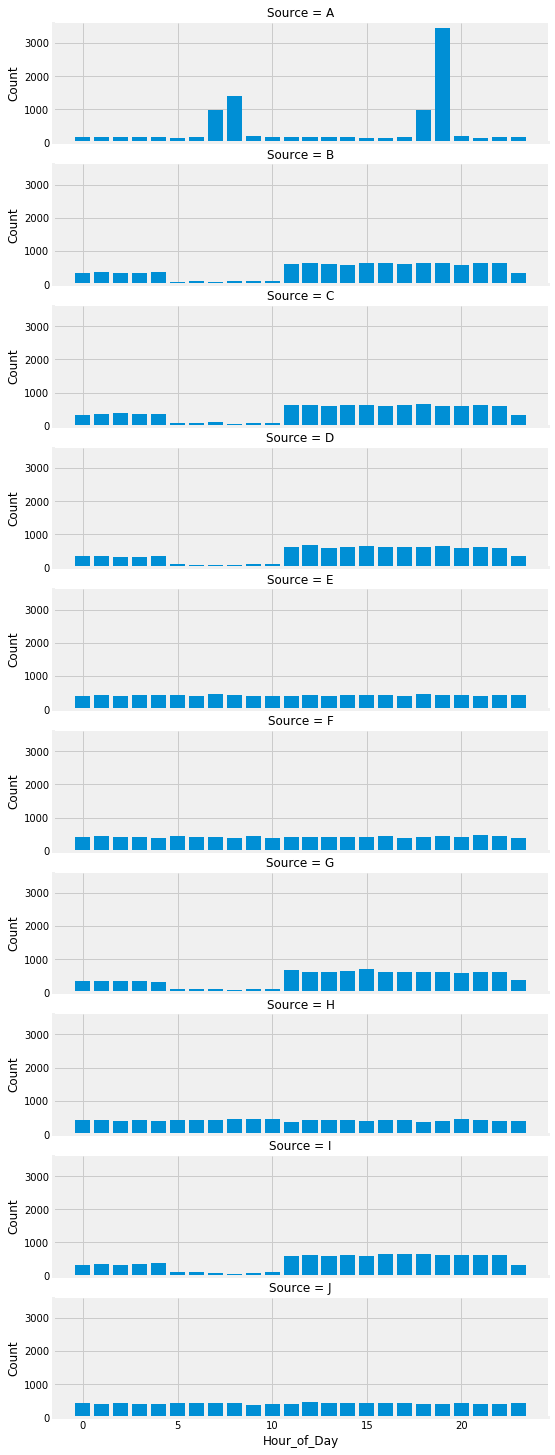

In [7]:
# Make a grid of plots of hour-by-hour activity for each source
g = sns.FacetGrid(givt_by_src, row='Source')
g.map(plt.bar, 'Hour_of_Day', 'Count')
g.fig.set_size_inches(10,20)

From the series of plots above, the activity from half of the sources (B, C, D, G and I) exhibit patterns which appear low-risk and not suspicious -- these *look* like typical user patterns in aggregate with peaks in traffic over time periods corresponding to work hours which decline to minimal volumes over periods corresponding to overnight hours.

Sources whose activity appears higher-risk and suspicious fall into two classes:
* Unusual peaks over short time periods (Source A)
* Constant activity maintained over the entire 24 hours (Sources E, F, H, J)

Looking into the number of unique IP addresses, domains, and ISPs for each source reveals additional evidence to dig deeper into Source A in particular:

In [8]:
# Make dataframe of unique IP, ISP, and Domain counts for each Source
src_unique = pd.DataFrame(givt_df.groupby('Source').apply(lambda x: (x['IP'].nunique(), x['Domain'].nunique(), x['ISP'].nunique()))).rename(columns={0: 'uniques'})
new_cols = ['Unique_IP', 'Unique_Domain', 'Unique_ISP']
for n,col in enumerate(new_cols):
    src_unique[col] = src_unique['uniques'].apply(lambda location: location[n])

src_unique = src_unique.drop('uniques',axis=1)
src_unique

,Unique_IP,Unique_Domain,Unique_ISP
Source,,,
A,50,1,5
B,4033,1,7
C,4308,7,7
D,4850,8,7
E,1923,3,7
F,1960,5,7
G,5347,6,7
H,3679,6,7
I,5511,9,7


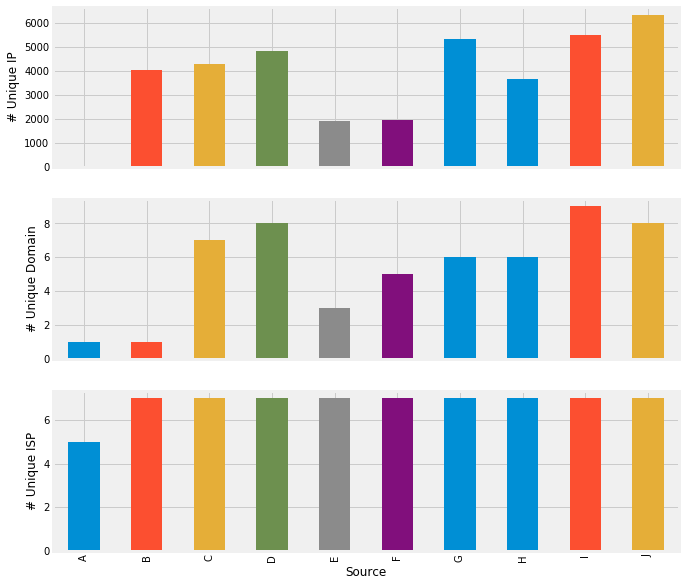

In [9]:
# Plot the corresponding counts for unique IPs, Domains, and ISPs by source
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10), sharex=True)

src_unique['Unique_IP'].plot.bar(ax=ax1)
ax1.set_ylabel('# Unique IP')

src_unique['Unique_Domain'].plot.bar(ax=ax2)
ax2.set_ylabel('# Unique Domain')

src_unique['Unique_ISP'].plot.bar(ax=ax3)
ax3.set_ylabel('# Unique ISP');

The hourly activity associated with Source A at its two peaks is 2 to 6 times that of any hour for any source, generated from by far the fewest unique IP addresses, domains, and ISPs. The combination of the unusual pattern of traffic and its distribution across few users and a single domain warrant the most focus on Source A to start, followed by the four sources which maintain a constant level of activity over all hours, and then the five sources whose activity follows typical user patterns.

### Analysis of  Source A

Examining the unique ISPs does not raise any suspicions but the single unique domain responsible for all of the traffic associated with this source definitely does; this is an isolated, generically-named blog which likely does not exist for anyone named Joe to document his life. 

In [10]:
givt_a = givt_df.loc[givt_df['Source'] == 'A']
givt_a['ISP'].unique()

array(['Comcast', 'Spectrum', 'AT&T', 'Wide Open West', 'Verizon FiOS'],
      dtype=object)

In [11]:
givt_a['Domain'].unique()

array(['joescoolblog.com'], dtype=object)

Looking at the unique IPs hour-by-hour below, it seems that the peaks are largely generated by 10-20 individual IPs. Source A's traffic  should be classified as **near certain** to be fraudulent, and is associated with ad requests that:
* **are being produced at an unnatural scale by a small number of users** and
* **have been made by scrapers or other self-identified bots visiting the site** 

using a domain without any legitimate content to generate fraudulent traffic. Source A should be **ejected** from the exchange.

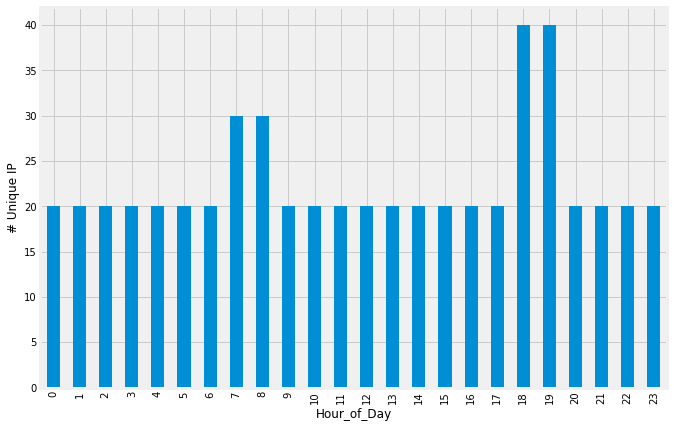

In [12]:
pd.DataFrame(givt_a.groupby('Hour_of_Day').apply(lambda x: x['IP'].nunique())).plot.bar(figsize=(10,7), legend=False)
plt.ylabel('# Unique IP');

### Analysis of sources maintaining a constant level of activity

These sources will be examined in descending order of assessed fraudulence. The assessments will begin with Source F, followed by Sources J, H and E. Below is a short function producing some visualizations to support these assessments for each source. 

In [13]:
def analyze_src(df, src_str):
    '''
        Given:
            df, dataframe of ad-placement sales like this sample data
            src_str, string of the source name
        Create bar plots of the source's activity:
            -By ISP
            -By Domain
            -By Browser
            -By IP
    '''
    
    # Just this source's data
    df = df.loc[df['Source'] == src_str]
    
    # Plot by ISP
    df.groupby(['ISP']).count()[['Source']].plot.barh(legend=False)
    plt.xlabel('Count')
    
    # Plot by Domain
    df.groupby(['Domain']).count()[['Source']].plot.barh(legend=False)
    plt.xlabel('Count')
    
    # Plot by Browser
    df.groupby(['Browser']).count()[['Source']].plot.barh(legend=False)
    plt.xlabel('Count')
    
    # Plot by IP
    df.groupby(['IP']).count()[['Source']].plot.barh(legend=False)
    plt.xlabel('Count')
    plt.yticks([])

#### Source F

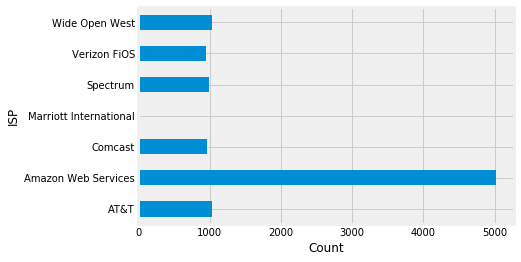

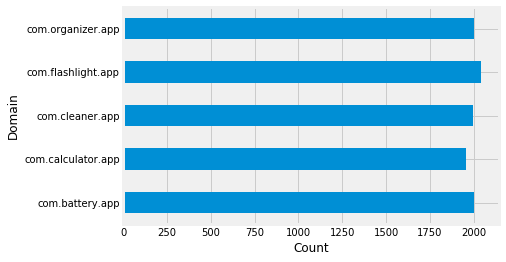

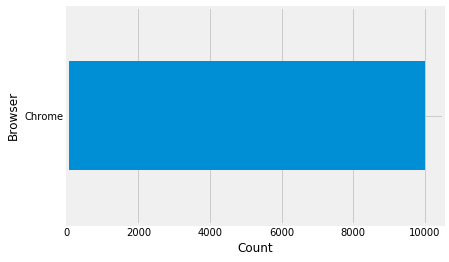

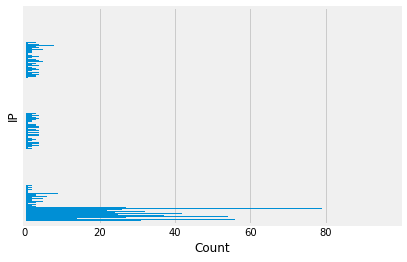

In [14]:
analyze_src(givt_df, 'F')

From the above output, Source F's traffic overwhelmingly originates from Amazon Web Services and built-in mobile device applications such as "calculator" and "organizer," whose presence as domains for ad requests is suspicious. There is also an uneven distribution of this activity across IPs.

Based on this evidence, Source F's traffic  should be classified as **near certain** to be fraudulent, and is primarily associated with **ad requests that appear to come from scripts running off data center servers**. Source F should be **ejected** from the exchange.

#### Source J

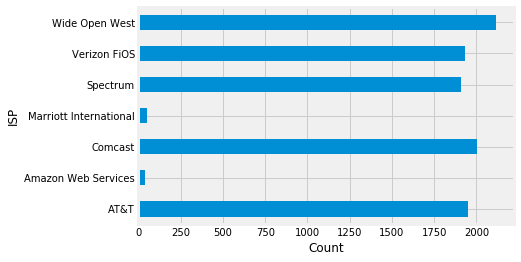

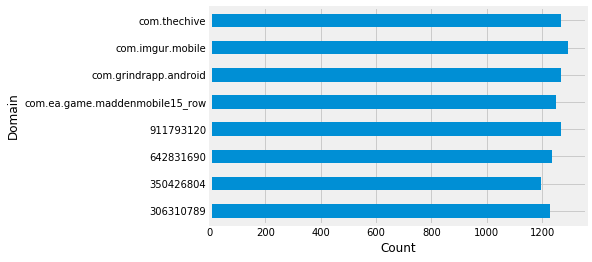

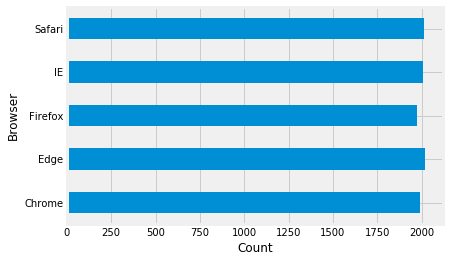

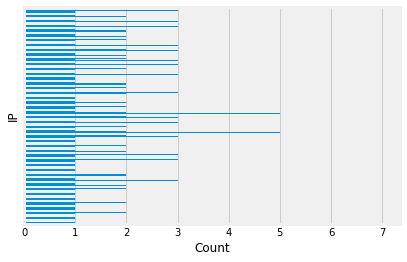

In [15]:
analyze_src(givt_df, 'J')

There is nothing immediately suspicious in the distribution of activity across IPs, ISPs, browsers or domains. However, the domains are all mobile applications and there is a near-even distribution across five different browsers, including several not typically used on mobile, indicating suspicious inconsistencies in the traffic. 

Source J should be classified as **very likely** to be fraudulent, and associated with ad requests that 

* **show signs of browser/IP manipulation (e.g., request inconsistencies), implying that the true source of the traffic is being obscured through spoofing** and
* **have been made by scrapers or other self-identified bots visiting the site**. 

Source J should be **ejected** from the exchange.

#### Source H

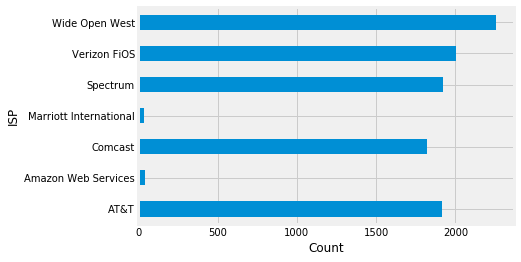

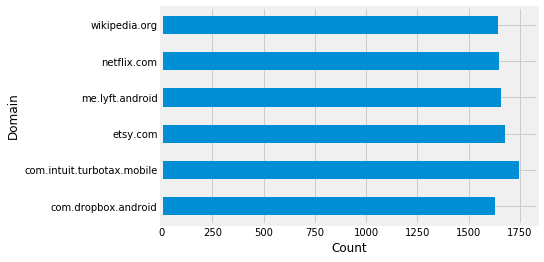

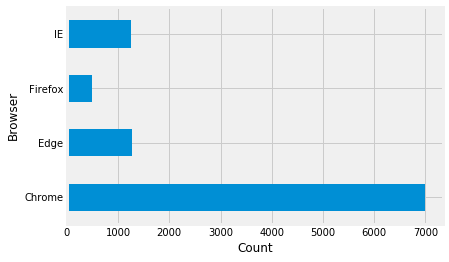

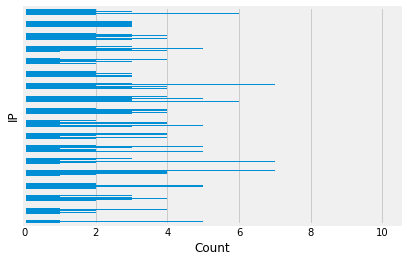

In [16]:
analyze_src(givt_df, 'H')

Again, there is nothing immediately suspicious in the distribution of activity across IPs, ISPs, browsers or domains. The domains are not overwhelmingly of one type and activity is primarily associated with Chrome. The activity associated with Source H is only suspicious due to the constant level of activity over all hours. Source H should be considered only **moderately likely** to be fraudulent and possibly associated with **ad requests that have been made by scrapers or other self-identified bots visiting the site**. Source J should **not be ejected but have a chargeback request** from the exchange.

#### Source E

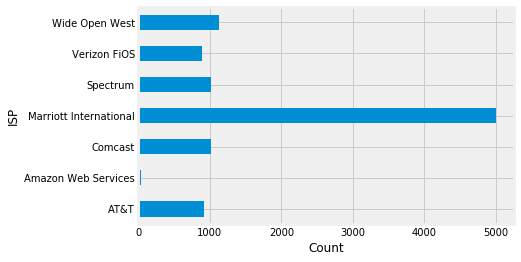

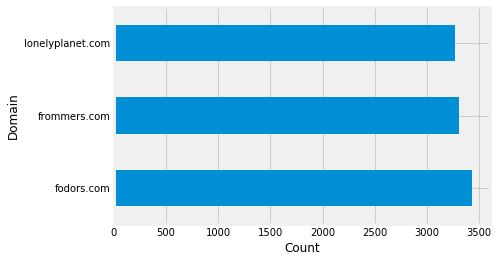

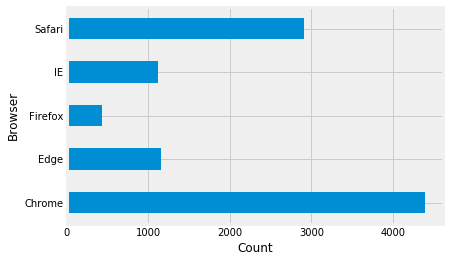

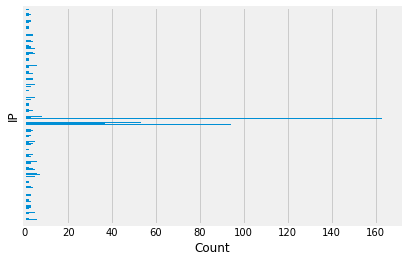

In [17]:
analyze_src(givt_df, 'E')

While activity overwhelmingly originates from a single ISP (Marriott International) and heavily concentrates around a few IPs and relatively few domains, the only apparent suspicious activity is the constant hour-by-hour volume -- the activity looks to be associated with users who are travelling, possibly explaining the potentially anomalous pattern. Source E should be classified as **unlikely** to be fraudulent, and possibly associated with **ad requests that have been made by scrapers or other self-identified bots visiting the site**. Source E should **not be ejected nor require a chargeback request**. 

### Analysis of sources without problematic patterns of activity but with concerns

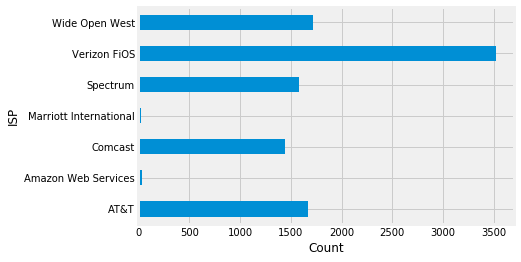

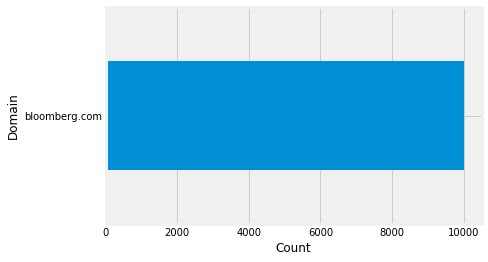

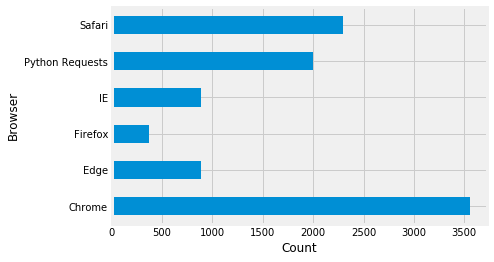

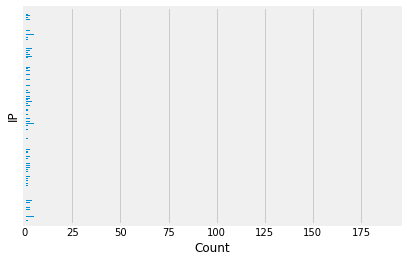

In [18]:
analyze_src(givt_df, 'B')

Nothing is suspicious from the activity as distributed across IPs or ISPs, but there are some concerns with all activity originating from a single domain with "Python Requests" also showing up as the third most active browser. Given the data that is typically associated with the single domain (bloomberg.com), the presence of "Python Requests" is less problematic, however. The single domain is legitimate unlike in Source A and may reflect use of a corporate network. Source B should be considered **unlikely** to be fraudulent.